In [1]:
import re
import ast

import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [2]:
def evaluate_data(data, prediction_col):
    y = data['Relevance code'].tolist()
    y_predict = data[prediction_col].tolist()
    scores = {
            'Sample size': len(data),
            'accuracy': accuracy_score(y, y_predict),
            'f1': f1_score(y, y_predict, average='binary'),
            'precision_score': precision_score(y, y_predict, zero_division=0, average='binary'),
            'recall_score': recall_score(y, y_predict, zero_division=0, average='binary')}
    return scores

## Import data

In [3]:
cd ..

/Users/gallaghe/Code/nutrition-labels


In [4]:
ensemble_date = '201118'
ensemble_info = f'data/processed/ensemble/{ensemble_date}_training_information_1models.txt'
ensemble_results_file = f'data/processed/ensemble/{ensemble_date}_all_ensemble_results.csv'
grant_file = 'data/raw/wellcome-grants-awarded-2005-2019.csv'

In [5]:
# Import the models names and training file name
with open(ensemble_info, "r") as f:
    for line in f.readlines():
        if 'Ensemble models' in line:
            models = re.sub('Ensemble models: ', '', line)
            models = ast.literal_eval(models)
models

['count_SVM_201022',
 'bert_SVM_scibert_201022',
 'bert_SVM_bert_201022',
 'tfidf_log_reg_201022']

In [6]:
# Import the ensemble results and which data was used in the test set
ensemble_data = pd.read_csv(ensemble_results_file)

# Import the grant data
grant_data = pd.read_csv(grant_file)
grant_data.drop_duplicates(['Internal ID'], inplace=True)

# Merge test data with grant info
test_results = ensemble_data.loc[ensemble_data['How has this grant been used before?']=='Test data'].reset_index(drop=True)
test_results = pd.merge(
    test_results,
    grant_data,
    how = 'left',
    on = ['Internal ID']
    )

In [7]:
model_names = [
    f'Ensemble predictions - {num_models} models' for num_models in range(1, 5)
    ] + [f'{model} predictions' for model in models]
model_names

['Ensemble predictions - 1 models',
 'Ensemble predictions - 2 models',
 'Ensemble predictions - 3 models',
 'Ensemble predictions - 4 models',
 'count_SVM_201022 predictions',
 'bert_SVM_scibert_201022 predictions',
 'bert_SVM_bert_201022 predictions',
 'tfidf_log_reg_201022 predictions']

### The test results for each model

In [8]:
all_test_results = []
for model_name in model_names:
    result = evaluate_data(test_results, model_name)
    column_results = {
            'Model name': model_name,
            'Data type': 'All'
        }
    for metric, value in result.items():
        column_results[metric] = value
    all_test_results.append(column_results)

all_test_results_df = pd.DataFrame(all_test_results)
all_test_results_df

,Model name,Data type,Sample size,accuracy,f1,precision_score,recall_score
0,Ensemble predictions - 1 models,All,107,0.841121,0.859504,0.787879,0.945455
1,Ensemble predictions - 2 models,All,107,0.878505,0.884956,0.862069,0.909091
2,Ensemble predictions - 3 models,All,107,0.869159,0.872727,0.872727,0.872727
3,Ensemble predictions - 4 models,All,107,0.841121,0.831683,0.913043,0.763636
4,count_SVM_201022 predictions,All,107,0.841121,0.846847,0.839286,0.854545
5,bert_SVM_scibert_201022 predictions,All,107,0.878505,0.878505,0.903846,0.854545
6,bert_SVM_bert_201022 predictions,All,107,0.869159,0.881356,0.825397,0.945455
7,tfidf_log_reg_201022 predictions,All,107,0.841121,0.844037,0.851852,0.836364


In [9]:
# Filter by just the models that pass the thresholds

f1_cutoff = 0.8
precision_cutoff = 0.82
recall_cutoff = 0.82

all_test_results_df = all_test_results_df.loc[
    ((all_test_results_df['f1']>=f1_cutoff) & (all_test_results_df['precision_score']>=precision_cutoff) & (all_test_results_df['recall_score']>=recall_cutoff))
]
model_names = all_test_results_df['Model name'].tolist()
model_names

['Ensemble predictions - 2 models',
 'Ensemble predictions - 3 models',
 'count_SVM_201022 predictions',
 'bert_SVM_scibert_201022 predictions',
 'bert_SVM_bert_201022 predictions',
 'tfidf_log_reg_201022 predictions']

In [10]:
# Are any of the models in the lower percentage for both recall AND precision?
# If so remove
lower_per_thresh = 0.5
lower_num_thresh = round(len(all_test_results_df)*lower_per_thresh)
lower_num_thresh

3

In [11]:
worst_precision_models = all_test_results_df.sort_values(
    by=['precision_score'],ascending=False)['Model name'][-lower_num_thresh:].to_list()
worst_precision_models

['tfidf_log_reg_201022 predictions',
 'count_SVM_201022 predictions',
 'bert_SVM_bert_201022 predictions']

In [12]:
worst_recall_models = all_test_results_df.sort_values(
    by=['recall_score'],ascending=False)['Model name'][-lower_num_thresh:].to_list()
worst_recall_models

['count_SVM_201022 predictions',
 'bert_SVM_scibert_201022 predictions',
 'tfidf_log_reg_201022 predictions']

In [13]:
models_to_remove = list(set(worst_precision_models).intersection(set(worst_recall_models)))
models_to_remove

['count_SVM_201022 predictions', 'tfidf_log_reg_201022 predictions']

In [14]:
model_names = [m for m in model_names if m not in models_to_remove]
model_names

['Ensemble predictions - 2 models',
 'Ensemble predictions - 3 models',
 'bert_SVM_scibert_201022 predictions',
 'bert_SVM_bert_201022 predictions']

In [15]:
all_test_results_df.loc[all_test_results_df['Model name'].isin(model_names)]

,Model name,Data type,Sample size,accuracy,f1,precision_score,recall_score
1,Ensemble predictions - 2 models,All,107,0.878505,0.884956,0.862069,0.909091
2,Ensemble predictions - 3 models,All,107,0.869159,0.872727,0.872727,0.872727
5,bert_SVM_scibert_201022 predictions,All,107,0.878505,0.878505,0.903846,0.854545
6,bert_SVM_bert_201022 predictions,All,107,0.869159,0.881356,0.825397,0.945455


## Evaluate fairness
For these selected models only

In [17]:
# Found by manually looking at the list in the test data (so might not be conclusive!)
golden_triangle = [
    'University College London', 'Imperial College London', "King's College London",
    'University of Oxford',
    'University of Cambridge'
    ]

In [18]:
# Golden triangle or not
test_results['Recipient organisation'] = ['Golden triangle' if org in golden_triangle else 'Not golden triangle' for org in test_results['Recipient Org:Name']]

# Greater london, international or not
region_grouped = []
for region in test_results['Region']:
    if region == 'Greater London':
        region_grouped.append('Greater London')
    elif region == 'International':
        region_grouped.append('International')
    else:
        region_grouped.append('UK, not greater London')
test_results['Region grouped'] = region_grouped

In [19]:
data_types = ['Recipient organisation', 'Region grouped']

In [20]:
fairness_results = []
for model_name in model_names:
    for column in data_types:
        result = test_results.groupby(column).apply(lambda x: evaluate_data(x, model_name)).to_dict()
        for column_type, type_results in result.items():
            column_results = {
                'Model name': model_name,
                'Data type': column,
                'Type': column_type
            }
            for metric, value in type_results.items():
                column_results[metric] = value
            fairness_results.append(column_results)

fairness_results_df = pd.DataFrame(fairness_results)
fairness_results_df.to_csv(f'data/processed/fairness_results_{ensemble_date}.csv')
fairness_results_df

,Model name,Data type,Type,Sample size,accuracy,f1,precision_score,recall_score
0,Ensemble predictions - 2 models,Recipient organisation,Golden triangle,41,0.878049,0.878049,0.818182,0.947368
1,Ensemble predictions - 2 models,Recipient organisation,Not golden triangle,66,0.878788,0.888889,0.888889,0.888889
2,Ensemble predictions - 2 models,Region grouped,Greater London,30,0.900000,0.909091,0.833333,1.000000
3,Ensemble predictions - 2 models,Region grouped,International,10,0.800000,0.750000,0.600000,1.000000
4,Ensemble predictions - 2 models,Region grouped,"UK, not greater London",67,0.880597,0.888889,0.914286,0.864865
5,Ensemble predictions - 3 models,Recipient organisation,Golden triangle,41,0.878049,0.871795,0.850000,0.894737
6,Ensemble predictions - 3 models,Recipient organisation,Not golden triangle,66,0.863636,0.873239,0.885714,0.861111
7,Ensemble predictions - 3 models,Region grouped,Greater London,30,0.866667,0.866667,0.866667,0.866667
8,Ensemble predictions - 3 models,Region grouped,International,10,0.800000,0.750000,0.600000,1.000000
9,Ensemble predictions - 3 models,Region grouped,"UK, not greater London",67,0.880597,0.888889,0.914286,0.864865


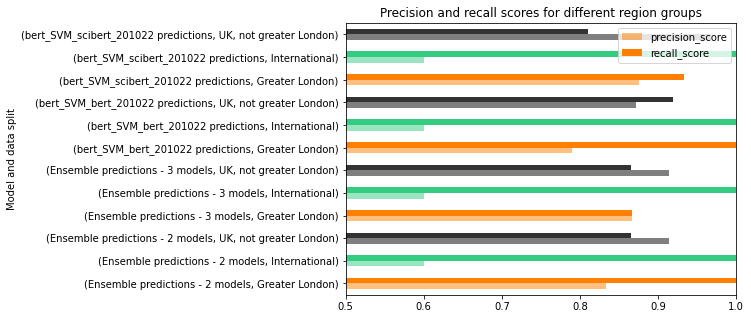

In [21]:
region = fairness_results_df.loc[fairness_results_df['Data type']=='Region grouped']
ax = region.groupby(['Model name', 'Type'])[['precision_score', 'recall_score']].sum().plot.barh(
    color=[[(1,0.5,0,0.5), (0.2,0.8,0.5,0.5), (0,0,0,0.5)], [(1,0.5,0,1), (0.2,0.8,0.5,1), (0,0,0,0.8)]],xlabel='Model and data split',
    title = 'Precision and recall scores for different region groups',
    xlim = (0.5,1), figsize=(7,5)
);
ax.figure.savefig('docs/precrec_regions_incinternational.jpeg', bbox_inches='tight');

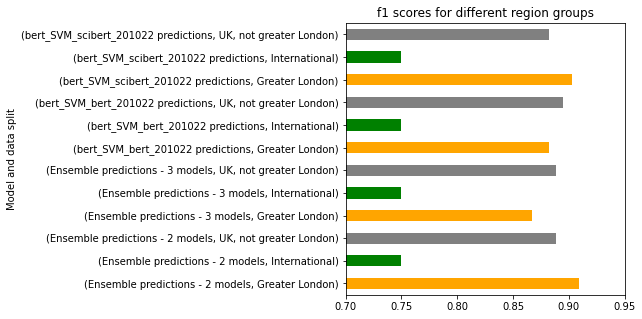

In [22]:
region = fairness_results_df.loc[fairness_results_df['Data type']=='Region grouped']
ax = region.groupby(['Model name', 'Type'])['f1'].sum().plot.barh(
    color=['orange', 'green', 'grey'], xlabel='Model and data split', title = 'f1 scores for different region groups',
    xlim = (0.7,0.95), figsize=(5,5)
);
ax.figure.savefig('docs/f1_regions_incinternational.jpeg', bbox_inches='tight');

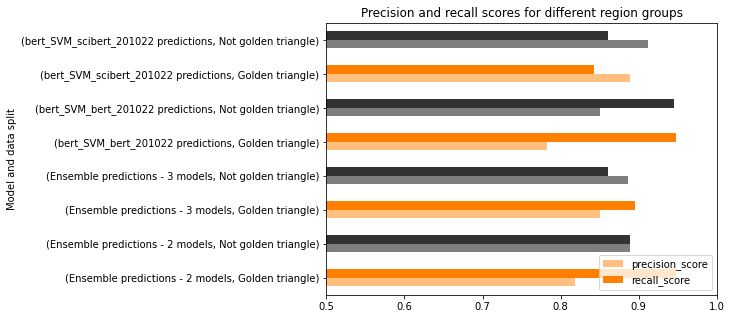

In [23]:
goldtri = fairness_results_df.loc[fairness_results_df['Data type']=='Recipient organisation']
ax = goldtri.groupby(['Model name', 'Type'])[['precision_score', 'recall_score']].sum().plot.barh(
    color=[[(1,0.5,0,0.5), (0,0,0,0.5)], [(1,0.5,0,1), (0,0,0,0.8)]],xlabel='Model and data split',
    title = 'Precision and recall scores for different region groups',
    xlim = (0.5,1), figsize=(7,5)
);
ax.figure.savefig('docs/precrec_goldentri.jpeg', bbox_inches='tight');

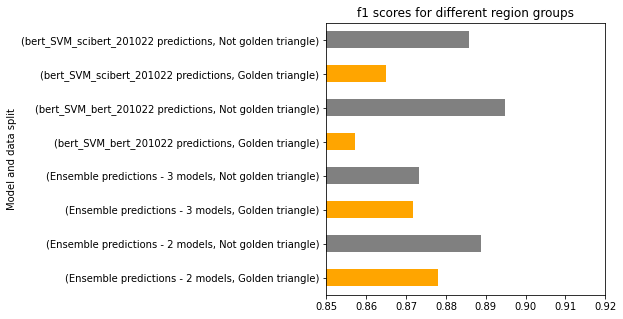

In [24]:
goldtri = fairness_results_df.loc[fairness_results_df['Data type']=='Recipient organisation']
ax = goldtri.groupby(['Model name', 'Type'])['f1'].sum().plot.barh(
    color=['orange', 'grey'], xlabel='Model and data split', title = 'f1 scores for different region groups',
    xlim = (0.85,0.92), figsize=(5,5)
);
ax.figure.savefig('docs/f1_goldentri.jpeg', bbox_inches='tight');

### Remove international group
n=10 and the result is consistent amongst models anyway

In [25]:
fairness_results_df = fairness_results_df.loc[fairness_results_df['Type'] != 'International']
fairness_results_df

,Model name,Data type,Type,Sample size,accuracy,f1,precision_score,recall_score
0,Ensemble predictions - 2 models,Recipient organisation,Golden triangle,41,0.878049,0.878049,0.818182,0.947368
1,Ensemble predictions - 2 models,Recipient organisation,Not golden triangle,66,0.878788,0.888889,0.888889,0.888889
2,Ensemble predictions - 2 models,Region grouped,Greater London,30,0.900000,0.909091,0.833333,1.000000
4,Ensemble predictions - 2 models,Region grouped,"UK, not greater London",67,0.880597,0.888889,0.914286,0.864865
5,Ensemble predictions - 3 models,Recipient organisation,Golden triangle,41,0.878049,0.871795,0.850000,0.894737
6,Ensemble predictions - 3 models,Recipient organisation,Not golden triangle,66,0.863636,0.873239,0.885714,0.861111
7,Ensemble predictions - 3 models,Region grouped,Greater London,30,0.866667,0.866667,0.866667,0.866667
9,Ensemble predictions - 3 models,Region grouped,"UK, not greater London",67,0.880597,0.888889,0.914286,0.864865
10,bert_SVM_scibert_201022 predictions,Recipient organisation,Golden triangle,41,0.878049,0.864865,0.888889,0.842105
11,bert_SVM_scibert_201022 predictions,Recipient organisation,Not golden triangle,66,0.878788,0.885714,0.911765,0.861111


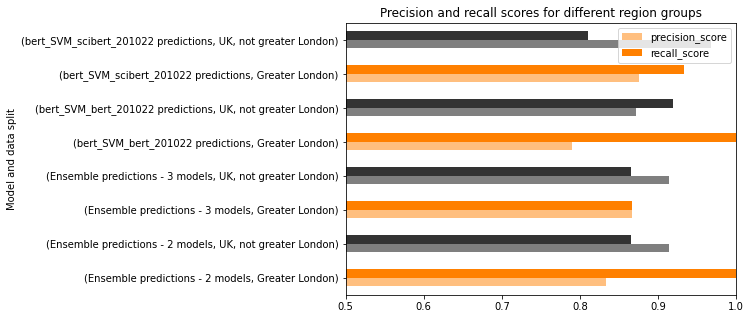

In [26]:
region = fairness_results_df.loc[fairness_results_df['Data type']=='Region grouped']
ax = region.groupby(['Model name', 'Type'])[['precision_score', 'recall_score']].sum().plot.barh(
    color=[[(1,0.5,0,0.5), (0,0,0,0.5)], [(1,0.5,0,1), (0,0,0,0.8)]],xlabel='Model and data split',
    title = 'Precision and recall scores for different region groups',
    xlim = (0.5,1), figsize=(7,5)
);
ax.figure.savefig('docs/precrec_region.jpeg', bbox_inches='tight');

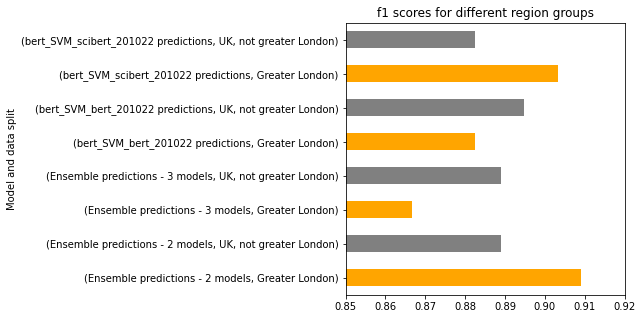

In [27]:
region = fairness_results_df.loc[fairness_results_df['Data type']=='Region grouped']
ax = region.groupby(['Model name', 'Type'])['f1'].sum().plot.barh(
    color=['orange', 'grey'], xlabel='Model and data split', title = 'f1 scores for different region groups',
    xlim = (0.85,0.92), figsize=(5,5)
);
ax.figure.savefig('docs/f1_region.jpeg', bbox_inches='tight');

### The range of results for each data type and model
Max value - min value for the groups

We would want to minimise this difference

In [28]:
ranges_grouped = fairness_results_df.groupby(
    ['Model name', 'Data type']
)[['f1', 'precision_score', 'recall_score']].apply(lambda x: x.max()-x.min())
ranges_grouped

f1  \
Model name                          Data type                          
Ensemble predictions - 2 models     Recipient organisation  0.010840   
                                    Region grouped          0.020202   
Ensemble predictions - 3 models     Recipient organisation  0.001445   
                                    Region grouped          0.022222   
bert_SVM_bert_201022 predictions    Recipient organisation  0.037594   
                                    Region grouped          0.012384   
bert_SVM_scibert_201022 predictions Recipient organisation  0.020849   
                                    Region grouped          0.020873   

                                                            precision_score  \
Model name                          Data type                                 
Ensemble predictions - 2 models     Recipient organisation         0.070707   
                                    Region grouped                 0.080952   
Ensemble predictions - 3 models     Recipient organisation         0.035714   
                                    Region grouped                 0.047619   
bert_SVM_bert_201022 predictions    Recipient organisation         0.067391   
                                    Region grouped                 0.082321   
bert_SVM_scibert_201022 predictions Recipient organisation         0.022876   
                                    Region grouped                 0.092742   

                                                            recall_score  
Model name                          Data type                             
Ensemble predictions - 2 models     Recipient organisation      0.058480  
                                    Region grouped              0.135135  
Ensemble predictions - 3 models     Recipient organisation      0.033626  
                                    Region grouped              0.001802  
bert_SVM_bert_201022 predictions    Recipient organisation      0.002924  
                                    Region grouped              0.081081  
bert_SVM_scibert_201022 predictions Recipient organisation      0.019006  
                                    Region grouped              0.122523

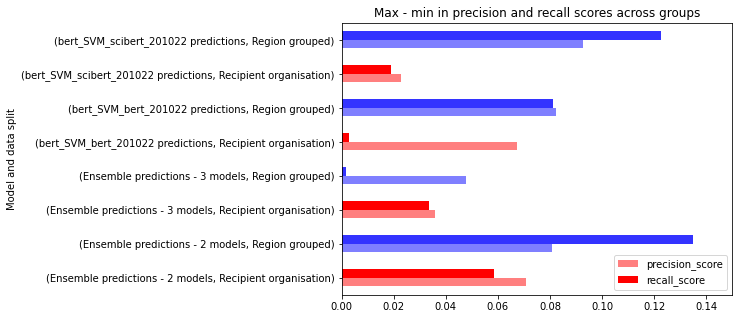

In [29]:
ax = ranges_grouped[['precision_score', 'recall_score']].plot.barh(
    color=[[(1,0,0,0.5), (0,0,1,0.5)], [(1,0,0,1), (0,0,1,0.8)]], xlabel='Model and data split',
    title = 'Max - min in precision and recall scores across groups',
    xlim = (0,0.15), figsize=(7,5)
);
ax.figure.savefig('docs/diff_precrec.jpeg', bbox_inches='tight');

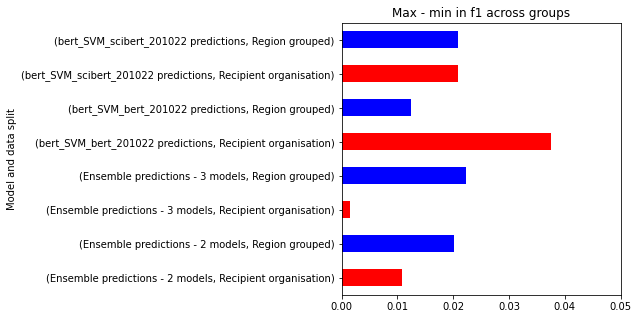

In [30]:
ax = ranges_grouped['f1'].plot.barh(
    color=['red', 'blue'], xlabel='Model and data split', title = 'Max - min in f1 across groups',
    xlim = (0,0.05), figsize=(5,5)
);
ax.figure.savefig('docs/diff_f1.jpeg', bbox_inches='tight');

### Which models have the lowest mean difference between groups?
Combine both the golden triangle and the region results

In [31]:
ranges_grouped.groupby('Model name').sum().sort_values(by=['f1'],ascending=True)

,f1,precision_score,recall_score
Model name,,,
Ensemble predictions - 3 models,0.023667,0.083333,0.035428
Ensemble predictions - 2 models,0.031042,0.151659,0.193615
bert_SVM_scibert_201022 predictions,0.041722,0.115618,0.141528
bert_SVM_bert_201022 predictions,0.049978,0.149712,0.084005


In [32]:
ranges_grouped.groupby('Model name').sum().sort_values(by=['precision_score'],ascending=True)

,f1,precision_score,recall_score
Model name,,,
Ensemble predictions - 3 models,0.023667,0.083333,0.035428
bert_SVM_scibert_201022 predictions,0.041722,0.115618,0.141528
bert_SVM_bert_201022 predictions,0.049978,0.149712,0.084005
Ensemble predictions - 2 models,0.031042,0.151659,0.193615


In [33]:
ranges_grouped.groupby('Model name').sum().sort_values(by=['recall_score'],ascending=True)

,f1,precision_score,recall_score
Model name,,,
Ensemble predictions - 3 models,0.023667,0.083333,0.035428
bert_SVM_bert_201022 predictions,0.049978,0.149712,0.084005
bert_SVM_scibert_201022 predictions,0.041722,0.115618,0.141528
Ensemble predictions - 2 models,0.031042,0.151659,0.193615


In [34]:
# sum(diffs in f1 between golden triangle groups) + sum(diffs in precision between region groups)
model_sum_diff_metrics = ranges_grouped.groupby('Model name').sum().sum(axis=1).sort_values()
pd.DataFrame(model_sum_diff_metrics)

,0
Model name,
Ensemble predictions - 3 models,0.142428
bert_SVM_bert_201022 predictions,0.283695
bert_SVM_scibert_201022 predictions,0.298868
Ensemble predictions - 2 models,0.376316
